In [1]:
from yahoo_fin.stock_info import get_data
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

## Use Yahoo API to load data


In [2]:
start= "01/01/2000"
end = "10/19/2023"
datafile = "../data/"
tk = "^VIX"

vix = get_data(tk, start_date = start, end_date = end, index_as_date = False,
     interval = "1d").set_index("date")
vix = vix[["close"]].rename(columns = {"close":"VIX"})

usd = get_data("DX-Y.NYB", start_date = start, end_date = end, index_as_date = False,interval = "1d").set_index("date")
usd = usd[["close"]].rename(columns = {"close":"USD"})

worldIx = get_data("MXWO.L", start_date = start, end_date = end, index_as_date = False,interval = "1d").set_index("date")
worldIx = worldIx[["close"]].rename(columns = {"close":"MSCI-W"})

In [3]:
## Save the Data
vix.to_csv(datafile + "VIX.csv", index = False)
usd.to_csv(datafile + "USD.csv", index = False)
worldIx.to_csv(datafile + "MSCI-W.csv", index = False)

In [12]:
## Concat the dataframe
data = pd.concat([vix, usd, worldIx], axis = 1)
data = data[~((data["VIX"].isna()) & (data["USD"].isna()) & (data["MSCI-W"].isna()))].ffill()
data = data.dropna()
data

,VIX,USD,MSCI-W
date,,,
2009-04-02,42.040001,84.449997,20.067699
2009-04-03,39.700001,84.169998,20.119200
2009-04-06,40.930000,84.570000,19.969900
2009-04-07,40.389999,85.290001,19.604500
2009-04-08,38.849998,85.360001,19.671400
...,...,...,...
2023-10-12,16.690001,106.570000,88.574997
2023-10-13,19.320000,106.650002,87.625000
2023-10-16,17.209999,106.239998,88.415001


## Correlation of uncertainty and Global Markets

In [13]:
## calculate difference 
back = data.copy()
data["delta_USD"] = np.log(data["USD"]).diff()
data["delta_MSCI-W"] = np.log(data["MSCI-W"]).diff()
data["log_MSCI-W"] = np.log(data["MSCI-W"])
data["VIX_MA20_d20"] = data["VIX"].shift(20).rolling(20).mean()
data["VIX_MA20"] = data["VIX"].rolling(20).mean()
data["VIX_d1"] = data["VIX"].shift(1)

data = data.dropna()

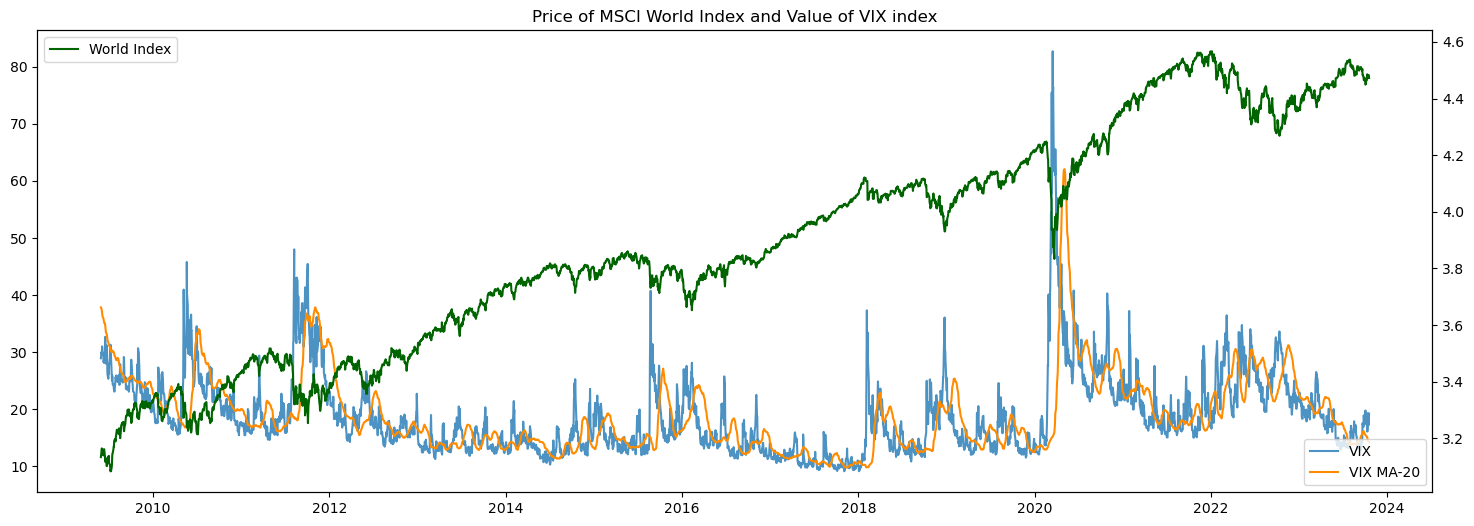

In [10]:
## plot the correlation of MSCI World Index & VIX
fig, ax1 = plt.subplots(1,1,figsize = (18,6))
ax1.plot(data["VIX"], label = "VIX", alpha = 0.8)
ax1.plot(data["VIX_MA20_d20"],color = "darkorange", label = "VIX MA-20")
ax2 = ax1.twinx()
ax2.plot(data["log_MSCI-W"],color = "darkgreen", label = "World Index")
ax1.legend(loc = 4)
ax2.legend(loc = 2)
plt.title("Price of MSCI World Index and Value of VIX index")
plt.savefig("VIX_MSCI.png")
plt.show()

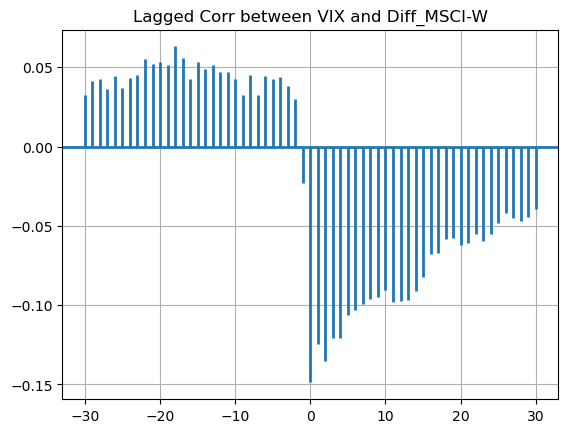

In [11]:
## plot correlation
y = data["delta_MSCI-W"] - data["delta_MSCI-W"].mean()
x = data["VIX"] - data["VIX"].mean()
plt.xcorr(x,y, usevlines=True, maxlags= 30, normed=True, lw=2)
plt.grid(True)
plt.title("Lagged Corr between VIX and Diff_MSCI-W")
plt.savefig("VIX_MSCI_xcorr.png")
plt.show()

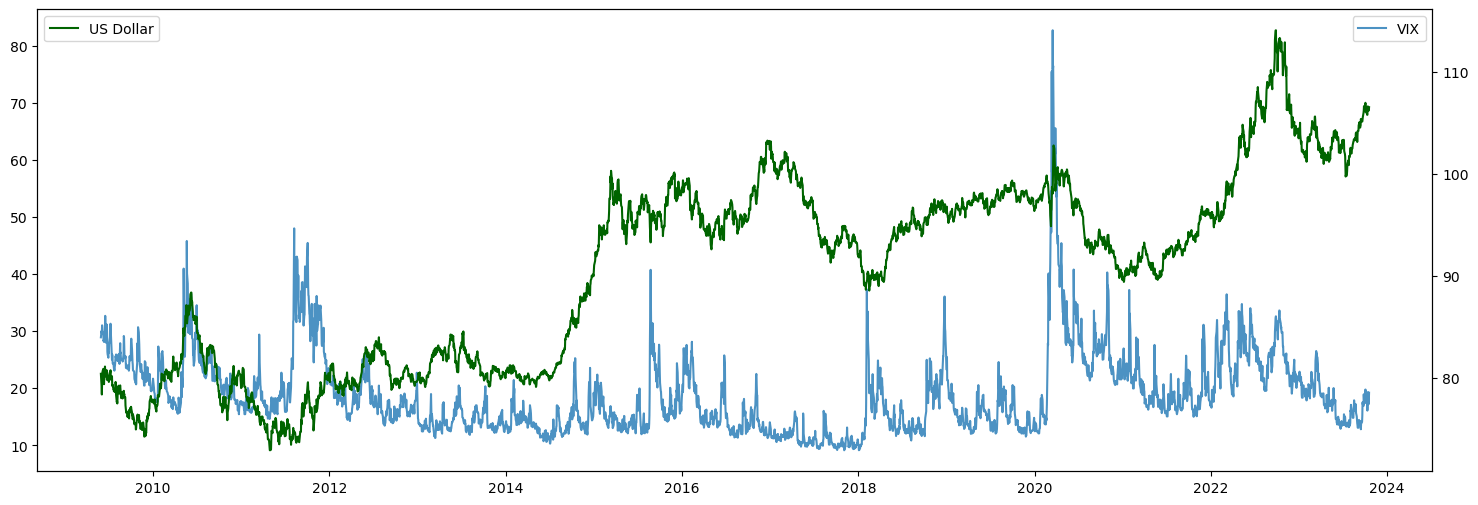

In [153]:
## plot the correlation of MSCI World Index & VIX
fig, ax1 = plt.subplots(1,1,figsize = (18,6))
ax1.plot(data["VIX"], label = "VIX", alpha = 0.8)
ax2 = ax1.twinx()
ax2.plot(data["USD"],color = "darkgreen", label = "US Dollar")
ax1.legend(loc = 0)
ax2.legend(loc = 2)
plt.show()

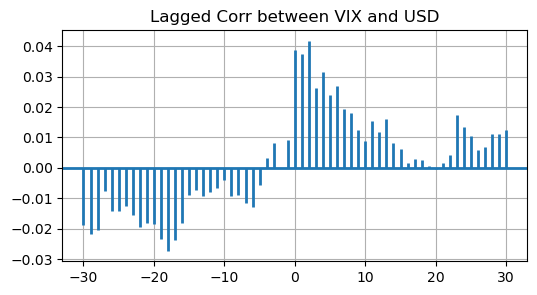

In [161]:
## plot correlation
plt.figure(figsize = (6,3))
y = data["delta_USD"] - data["delta_USD"].mean()
x = data["VIX"] - data["VIX"].mean()
plt.xcorr(x,y, usevlines=True, maxlags=30, normed=True, lw=2)
plt.grid(True)
plt.title("Lagged Corr between VIX and USD")
plt.show()

In [16]:
### Fitting the linear models
y = (data["delta_MSCI-W"] - data["delta_MSCI-W"].mean()) / data["delta_MSCI-W"].std() 
X = (data["VIX_d1"] - data["VIX_d1"].mean()) / data["VIX_d1"].std()
linearmodel = sm.OLS(y,X).fit()
linearmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           delta_MSCI-W   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.000
Method:                 Least Squares   F-statistic:                              1.866
Date:                Thu, 26 Oct 2023   Prob (F-statistic):                       0.172
Time:                        00:57:11   Log-Likelihood:                         -5251.5
No. Observations:                3702   AIC:                                  1.050e+04
Df Residuals:                    3701   BIC:                                  1.051e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
VIX_d1        -0.0225      0.016     -1.366      0.172      -0.055       0.010
==============================================================================
Omnibus:                      751.276   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9413.747
Skew:                          -0.598   Prob(JB):                         0.00
Kurtosis:                      10.720   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
y = (data["delta_USD"] - data["delta_USD"].mean()) / data["delta_USD"].std() 
X = (data["VIX"] - data["VIX"].mean()) / data["VIX"].std()
linearmodel = sm.OLS(y,X).fit()
linearmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              delta_USD   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):              0.001
Method:                 Least Squares   F-statistic:                              5.559
Date:                Thu, 26 Oct 2023   Prob (F-statistic):                      0.0184
Time:                        00:53:56   Log-Likelihood:                         -5249.6
No. Observations:                3702   AIC:                                  1.050e+04
Df Residuals:                    3701   BIC:                                  1.051e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
VIX            0.0387      0.016      2.358      0.018       0.007       0.071
==============================================================================
Omnibus:                      122.245   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              334.529
Skew:                          -0.034   Prob(JB):                     2.28e-73
Kurtosis:                       4.471   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""